In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.layers import Dense,Activation,Flatten
from keras.regularizers import l2,l1
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [7]:
import cv2
import pandas as pd
from imutils import paths
from PIL import Image
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

### importing DataSet

In [8]:
# Dataset is a size of (256,256)
# Dataset is converted into gray scale for better accuracy

dataset1 = tf.keras.preprocessing.image_dataset_from_directory("Query", shuffle = True,color_mode="grayscale")

Found 21471 files belonging to 48 classes.


### Train, Validation, Test split

In [4]:
def dataPartition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds




# calling train, test split

train_ds, val_ds, test_ds = dataPartition(dataset1)

In [10]:

# using prefetch method to Reduce computational power

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### pre-processing

In [13]:
# Normalizing Data

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Model1 - CNN

### Model building

In [10]:
# 6 conv-layers
# pooling - maxpooling
# filter - 3 x 3 
# activation - relu
# optimizer - adam
# loss - Sparse Categorical Crossentropy


model1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape= (32,256,256,1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(48, activation='softmax')
])

model1.build(input_shape=(32, 256, 256, 1))

model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Save Best Model in Dir

In [12]:
#save best model out-of-all epoch 
# best model is choosen based on validation accuracy score


saveBestModel = ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

### Fitting the Model 

In [13]:
# process
# batch size - 32
# epoch - 50
# saving best model

history1 = model1.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[saveBestModel]
)

Epoch 1/50
536/536 [==============================] - ETA: 0s - loss: 2.8578 - accuracy: 0.2321
Epoch 1: val_accuracy improved from -inf to 0.59328, saving model to models\best_model.h5
536/536 [==============================] - 597s 1s/step - loss: 2.8578 - accuracy: 0.2321 - val_loss: 1.4719 - val_accuracy: 0.5933
Epoch 2/50
536/536 [==============================] - ETA: 0s - loss: 1.2010 - accuracy: 0.6417
Epoch 2: val_accuracy improved from 0.59328 to 0.73461, saving model to models\best_model.h5
536/536 [==============================] - 597s 1s/step - loss: 1.2010 - accuracy: 0.6417 - val_loss: 0.8972 - val_accuracy: 0.7346
Epoch 3/50
536/536 [==============================] - ETA: 0s - loss: 0.7691 - accuracy: 0.7663
Epoch 3: val_accuracy improved from 0.73461 to 0.82276, saving model to models\best_model.h5
536/536 [==============================] - 596s 1s/step - loss: 0.7691 - accuracy: 0.7663 - val_loss: 0.5847 - val_accuracy: 0.8228
Epoch 4/50
536/536 [====================

Epoch 29/50
536/536 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9859
Epoch 29: val_accuracy did not improve from 0.97295
536/536 [==============================] - 594s 1s/step - loss: 0.0463 - accuracy: 0.9859 - val_loss: 0.1785 - val_accuracy: 0.9674
Epoch 30/50
536/536 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9904
Epoch 30: val_accuracy did not improve from 0.97295
536/536 [==============================] - 594s 1s/step - loss: 0.0287 - accuracy: 0.9904 - val_loss: 0.1801 - val_accuracy: 0.9706
Epoch 31/50
536/536 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9847
Epoch 31: val_accuracy did not improve from 0.97295
536/536 [==============================] - 596s 1s/step - loss: 0.0485 - accuracy: 0.9847 - val_loss: 0.1915 - val_accuracy: 0.9674
Epoch 32/50
536/536 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9873
Epoch 32: val_accuracy did not improve from 0.97295
536/536 

### Best models' validation accuracy 

In [19]:
max(history1.history['val_accuracy'])

0.9785447716712952

### Loading Best Model From Directory

In [3]:
from tensorflow.keras.models import load_model
best_model = load_model('models/best_model.h5')


# summary of best model 

best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)       

### Evalute best Model on Test Data

In [18]:
new_model.evaluate(test_ds)

68/68 [==============================] - 48s 279ms/step - loss: 0.1573 - accuracy: 0.9738


[0.1572905033826828, 0.973793089389801]

### plot Train Accuracy vs Validation Accuracy

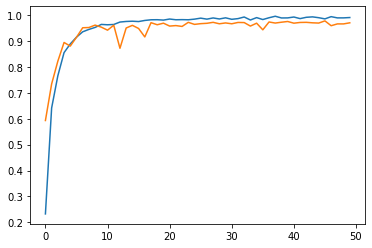

In [20]:
plt.plot(range(0,50),history13.history['accuracy'])
plt.plot(range(0,50),history13.history['val_accuracy'])

## Model 2 - Neural Network

### Load dataset

In [3]:
imagepath=list(paths.list_images("G:\GCR\Query"))

In [4]:
img = []
label = []
for image in imagepath:
    label.append(image.split('\\')[3])
    images = cv2.imread(image)
    imgGray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
    new_image=cv2.subtract(255, imgGray) 
    image_resize = (cv2.resize(new_image, (28,28)))
    
    img.append(image_resize)

### Create label

In [5]:
classes=np.unique(label)

In [6]:
df = pd.DataFrame(label).value_counts(sort=False)
label_num = []
j=0
for i in df:
    for z in range(i):
        label_num.append(j)  
    j+=1

### Train-Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(img, label_num, test_size=0.3)

### Data pre-processing

In [8]:
# Normalization
x_train= np.array(X_train)/255
x_test = np.array(X_test)/255

In [9]:
train_x = np.asarray(x_train)
train_y = np.asarray(y_train)
test_x = np.asarray(x_test)
test_y = np.asarray(y_test)

### Create NN model

#### Without regularization

In [19]:
model_nn = models.Sequential([
    layers.Flatten(),
    layers.Dense(200, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(48, activation='softmax')
])
model_nn.build(input_shape=[None,28,28])

In [25]:
model_nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 200)               157000    
                                                                 
 dense_9 (Dense)             (None, 150)               30150     
                                                                 
 dense_10 (Dense)            (None, 100)               15100     
                                                                 
 dense_11 (Dense)            (None, 48)                4848      
                                                                 
Total params: 207,098
Trainable params: 207,098
Non-trainable params: 0
_________________________________________________________________


#### With Dropout and L2 regularization

In [112]:
model_nn1 = models.Sequential([
    layers.Flatten(),
    layers.Dense(200, activation='relu',kernel_regularizer=l2(0.001)),
     layers.Dropout(0.3),
     layers.Dense(150, activation='relu',kernel_regularizer=l2(0.001)),
     layers.Dropout(0.3),
    layers.Dense(100, activation='relu',kernel_regularizer=l2(0.001)),
     layers.Dropout(0.3),
    layers.Dense(48, activation='softmax')
])
model_nn1.build(input_shape=[None,28,28])

In [113]:
model_nn1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 784)               0         
                                                                 
 dense_93 (Dense)            (None, 200)               157000    
                                                                 
 dropout_57 (Dropout)        (None, 200)               0         
                                                                 
 dense_94 (Dense)            (None, 150)               30150     
                                                                 
 dropout_58 (Dropout)        (None, 150)               0         
                                                                 
 dense_95 (Dense)            (None, 100)               15100     
                                                                 
 dropout_59 (Dropout)        (None, 100)             

### loss and optimizer

In [114]:
model_nn.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics=['accuracy'])


model_nn1.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics=['accuracy'])


### Train Model

In [22]:
# Training model without regularization

model_history = model_nn.fit(train_x,train_y,epochs=30,verbose=1, validation_split=0.1)

Epoch 1/30
423/423 [==============================] - 2s 3ms/step - loss: 3.3268 - accuracy: 0.1459 - val_loss: 2.7483 - val_accuracy: 0.2582
Epoch 2/30
423/423 [==============================] - 1s 3ms/step - loss: 2.3330 - accuracy: 0.3640 - val_loss: 2.2455 - val_accuracy: 0.3859
Epoch 3/30
423/423 [==============================] - 1s 3ms/step - loss: 1.7148 - accuracy: 0.5183 - val_loss: 2.1747 - val_accuracy: 0.4059
Epoch 4/30
423/423 [==============================] - 1s 3ms/step - loss: 1.2997 - accuracy: 0.6264 - val_loss: 2.0080 - val_accuracy: 0.4671
Epoch 5/30
423/423 [==============================] - 1s 3ms/step - loss: 0.9875 - accuracy: 0.7052 - val_loss: 2.0483 - val_accuracy: 0.4691
Epoch 6/30
423/423 [==============================] - 1s 2ms/step - loss: 0.7443 - accuracy: 0.7761 - val_loss: 2.2392 - val_accuracy: 0.4731
Epoch 7/30
423/423 [==============================] - 1s 2ms/step - loss: 0.5643 - accuracy: 0.8273 - val_loss: 2.3139 - val_accuracy: 0.4691
Epoch 

In [115]:
# Training model with regularization

model_history1 = model_nn1.fit(train_x,train_y,epochs=30,verbose=1, validation_split=0.1)

Epoch 1/30
423/423 [==============================] - 2s 4ms/step - loss: 4.1109 - accuracy: 0.0532 - val_loss: 3.6532 - val_accuracy: 0.1510
Epoch 2/30
423/423 [==============================] - 2s 4ms/step - loss: 3.5326 - accuracy: 0.1503 - val_loss: 3.1745 - val_accuracy: 0.2555
Epoch 3/30
423/423 [==============================] - 1s 3ms/step - loss: 3.1913 - accuracy: 0.2223 - val_loss: 2.9079 - val_accuracy: 0.3160
Epoch 4/30
423/423 [==============================] - 1s 3ms/step - loss: 2.9706 - accuracy: 0.2812 - val_loss: 2.7434 - val_accuracy: 0.3639
Epoch 5/30
423/423 [==============================] - 1s 3ms/step - loss: 2.7989 - accuracy: 0.3227 - val_loss: 2.6685 - val_accuracy: 0.3832
Epoch 6/30
423/423 [==============================] - 1s 3ms/step - loss: 2.6715 - accuracy: 0.3607 - val_loss: 2.5458 - val_accuracy: 0.4152
Epoch 7/30
423/423 [==============================] - 2s 4ms/step - loss: 2.5666 - accuracy: 0.3925 - val_loss: 2.4997 - val_accuracy: 0.4451
Epoch 

### Test Evalute

In [28]:
# Test evalute for model without regularized

model_nn.evaluate(test_x, test_y)

202/202 [==============================] - 0s 2ms/step - loss: 5.1799 - accuracy: 0.4752


[5.179867744445801, 0.47516298294067383]

In [116]:
# Test evalute for model with regularized

model_nn1.evaluate(test_x, test_y)

202/202 [==============================] - 0s 2ms/step - loss: 2.5466 - accuracy: 0.4776


[2.54655385017395, 0.47764667868614197]

### Visualization

Text(0.5, 1.0, 'Model without regularized')

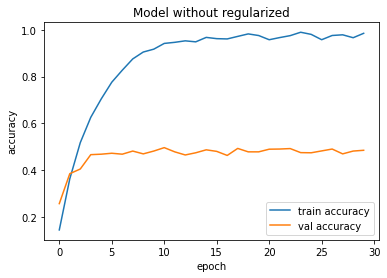

In [110]:
# non-regularized model

plt.plot(range(0,30),model_history.history['accuracy'], label = 'train accuracy')
plt.plot(range(0,30),model_history.history['val_accuracy'],label = 'val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Model without regularized')

Text(0.5, 1.0, 'Model with regularized')

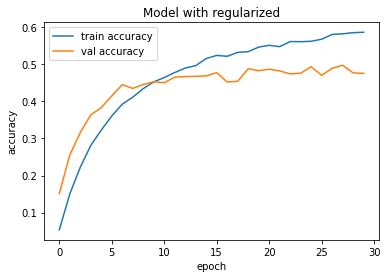

In [117]:
# regularized model

plt.plot(range(0,30),model_history1.history['accuracy'], label = 'train accuracy')
plt.plot(range(0,30),model_history1.history['val_accuracy'],label = 'val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Model with regularized')

## Model3 -KNN

In [53]:
imagepath=list(paths.list_images("G:\GCR\Query"))

In [32]:
img = []
label = []
for image in imagepath:
    label.append(image.split('\\')[3])
    images = cv2.imread(image)
    imgGray = color.rgb2gray(images)
    image_resize = (cv2.resize(imgGray, (100,100)))
    
    img.append(image_resize.flatten())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img, label_num, test_size=0.3)

In [6]:
Knn = KNeighborsClassifier(n_neighbors=1)

In [7]:
Knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [8]:
Knn.score(X_test,y_test)

0.3230363241229432

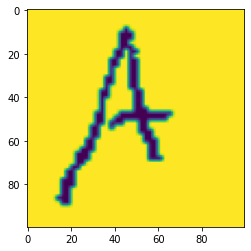

In [22]:
# colour histogram

alpha = img[50].reshape(100,100)
Beta = img[500].reshape(100,100)

plt.imshow(alpha)

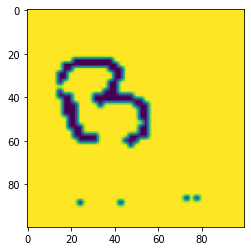

In [23]:
plt.imshow(Beta)

Text(0.5, 1.0, 'Histogram representation: alpha')

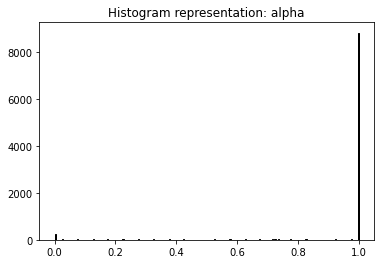

In [24]:
plt.hist(alpha.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.title('Histogram representation: alpha')

Text(0.5, 1.0, 'Histogram representation: Beta')

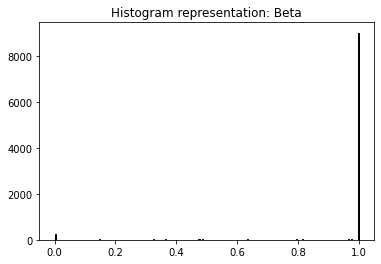

In [25]:
plt.hist(Beta.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.title('Histogram representation: Beta')

### KNN with Grid Search

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
knn2 = KNeighborsClassifier()

In [12]:
param_grid = {'n_neighbors': np.arange(1, 10), 'p': [1,2]}

In [13]:
knnCV = GridSearchCV(knn2, param_grid, cv=5)

In [14]:
knnCV.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'p': [1, 2]})

In [26]:
Results=knnCV.cv_results_

In [37]:
x=Results.get('params')
y=Results.get('mean_test_score')

Text(0.5, 1.0, 'distance = Manhattan distance')

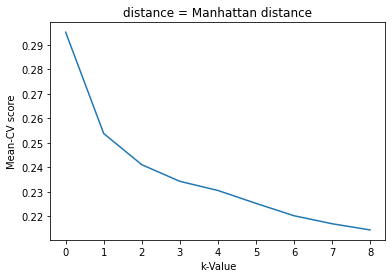

In [41]:
plt.plot(range(9),y[0::2])
plt.xlabel('k-Value')
plt.ylabel('Mean-CV score')
plt.title('distance = Manhattan distance')

Text(0.5, 1.0, 'distance = Euclidean distance')

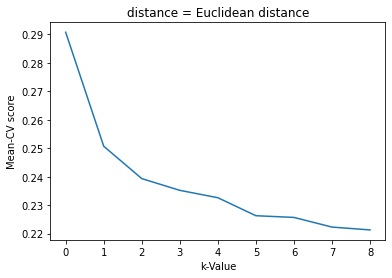

In [42]:
plt.plot(range(9),y[1::2])
plt.xlabel('k-Value')
plt.ylabel('Mean-CV score')
plt.title('distance = Euclidean distance')

In [43]:
knnCV.score(X_test,y_test)

0.32629618131015214

In [44]:
from sklearn.metrics import confusion_matrix

In [45]:
y_pred = knnCV.predict(X_test)

In [46]:
mat = confusion_matrix(y_test,y_pred)

In [50]:
import seaborn as sns

<AxesSubplot:>

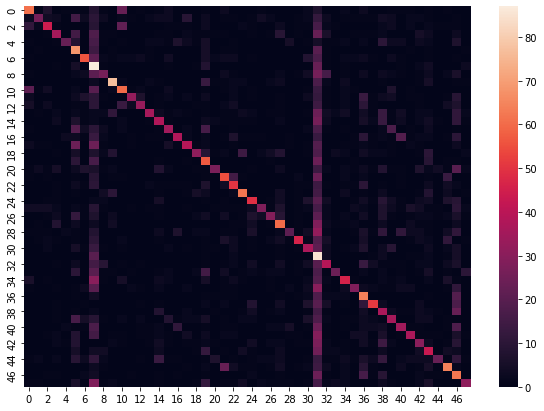

In [60]:
plt.figure(figsize = (10,7))
sns.heatmap(mat)